# Machine learning

The train datasets are loaded and preprocessed and then valid datasets. Then both types of datasets are merged and NaN values are filled. NaN values are filled using pipeline, fit_transform for train datasets and only transform for valid datasets. After NaN values are filled, then the decision rules are manually selected and evaluated for classification.

Once we have the correct preprocessed data, LabelEncoder will convert all necessary categorical attributes to numeric ones, also we remove unnecessary attributes. Next, using the Grid_search function, we will find the most optimal setting of hyperparameters, which we will use when creating the best decision tree. We will create two trees:

 - tree with filled NaN values using Linear Regression
 - tree with filled NaN values using Mean

The best manual rule are compared to the best tree.

# Table of Content

[Load train dataset and customize it](#load_the_data_1)

[Load valid dataset and customize it](#load_the_data_2)

[Filling NaN values](#fill_values)

[Rules](#rules)

[Complex rules](#complex_rules)

[Change categorical attributes to numerical](#change_attributes)

[Dropping insignificant attributes](#dropping_attributes)

[Finding the most optimal hyperparameters using Grid Search](#finding_hyperparameters)

[Visual representation of the treesh](#trees_visual)

In [1]:
import pandas as pd
import datetime
import statistics
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

Functions

In [2]:
def editColumn(df):
    df['personal_info'] = df['personal_info'].astype("string")
    for index, _ in df.iterrows():
        if isinstance(df.iloc[index]['personal_info'], str):
            occupation_and_other = df.iloc[index]['personal_info'].split('|')
            country_and_other = occupation_and_other[1].split('\r\r\n')
            marita_status_and_workclass = country_and_other[1].split(' -- ')

            df.loc[index, 'occupation'] = occupation_and_other[0]
            df.loc[index, 'country'] = country_and_other[0]
            df.loc[index, 'marital-status'] = marita_status_and_workclass[0]
            df.loc[index, 'workclass'] = marita_status_and_workclass[1]
    
    #other_train['occupation'] = other_train['occupation'].astype(np.st)
    #other_train['country'] = other_train['country'].astype(np.float64)
    #other_train['marital-status'] = other_train['marital-status'].astype(np.float64)
    #other_train['workclass'] = other_train['workclass'].astype(np.float64)

    del df['personal_info']

In [3]:
def replaceValueInAttribute(df):
    df['pregnant']= df['pregnant'].replace('F', 'FALSE')
    df['pregnant']= df['pregnant'].replace('f', 'FALSE')
    df['pregnant']= df['pregnant'].replace('T', 'TRUE')
    df['pregnant']= df['pregnant'].replace('t', 'TRUE')

In [4]:
def stripValues(df_1, df_2):
    df_1['relationship'] = df_1['relationship'].str.strip()
    df_1['education'] = df_1['education'].str.strip()
    df_1['income'] = df_1['income'].str.strip()
    
    df_2['sex'] = df_2['sex'].str.strip()

In [5]:
def changeNanValues(df):
    df['occupation'] = df['occupation'].replace('?', np.NaN)
    df['country'] = df['country'].replace('?', np.NaN)
    df['workclass'] = df['workclass'].replace('?', np.NaN)

In [6]:
def changeAgeAttribute(df):
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].astype('Int64')
    df['age'] = df['age'].astype('float64')
    df['age'] = df['age'].astype('str')
    df['age'] = df['age'].str.replace(r'\.0', '')
    df['age'] = df['age'].str.replace(r'00', '')
    df['age'] = df['age'].str.replace(r'-', '')
    df['age'] = df['age'].astype('float64')
    df['age'] = df['age'].astype('Int64')

In [7]:
def addNumber(row):
    suffix = ''
    if '-' in row:
        if len(row) == 8:
            suffix = '19'
    if '/' in row:
        if len(row) == 8:
            suffix = '19'
    if suffix == '19':
        row = suffix + row
      
    return row

In [8]:
def correctDate(date):
    if '/' in date:
        if date[2] == '/':
            x = datetime.datetime.strptime(date, '%d/%m/%Y').date()
            x.strftime('%Y-%m-%d')
            return x
        else:
            y = datetime.datetime.strptime(date, '%Y/%m/%d').date()
            y.strftime('%Y-%m-%d')
            return y
    if '-' in date:
        datetime.datetime.strptime(date, '%Y-%m-%d').date()
    return date 

In [9]:
def changeDate(df):
    date = df['date_of_birth'].str[:10]
    df['date_of_birth'] = df['date_of_birth'].str[:10]

    for i in range(len(date)): 
        date[i] = addNumber(date[i])

    df['date_of_birth'] = date

    for i in range(len(df['date_of_birth'])):
        df['date_of_birth'].iat[i] = correctDate(df['date_of_birth'].iat[i])

In [10]:
def fillNanDuplicates(data1, data2):
    
    for j in range(0, len(data1)):
        for i in range(0, len(data1.iloc[j, :])):
            if pd.isna(data1.iat[j, i]):
                data1.iloc[j, i] = data2.iat[j,i]

In [11]:
class mostFreq(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.most_frequency = [0] * len(columns)
        
    def fit(self, dataframe):
        for i in range(len(self.columns)):
            self.most_frequency[i] = dataframe[self.columns[i]].mode()[0]
        return self
    
    def transform(self, data):
        data_other = data.copy()
        for i in range(len(self.columns)):
            data_other[self.columns[i]] = data_other[self.columns[i]].apply(lambda x: self.most_frequency[i] if pd.isna(x) else x)
        return data_other



In [12]:
class meanFill(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.m = [0] * len(columns)
        
    def fit(self, dataframe, y=None):
        for i in range(len(self.columns)):
            self.m[i] = dataframe[self.columns[i]].mean()
            
        return self

    def transform(self, dataframe):
        dataframe_other = dataframe.copy()
        for i in range(len(self.columns)):
            dataframe_other[self.columns[i]] = dataframe_other[self.columns[i]].apply(lambda x: self.m[i] if pd.isna(x) else x)
        return dataframe_other

In [13]:
class linearRegression(TransformerMixin):
    def __init__(self, columns, model):
        self.column = columns
        self.model = model
        

    def fit(self, dataframe, y=None):
        numeric = dataframe.select_dtypes(include=[np.number]).dropna()
        other_numeric = numeric[numeric.columns.difference(self.column, sort = False)]
        specific_numeric = numeric[self.column]
        
        self.columns = other_numeric.columns.values
        self.model.fit(other_numeric, specific_numeric)
        
        return self

    
    def transform(self, dataframe):
        dataframe_other = dataframe.copy()
        for i in range(len(dataframe_other)):
            l = []
            if dataframe_other[self.column].iloc[i].isna().bool():
                for k in range(len(self.columns)):
                    if np.isnan(dataframe_other[self.columns[k]].iloc[i]):
                        l.append(dataframe_other[self.columns[k]].median())
                    else:
                        l.append(dataframe_other[self.columns[k]].iloc[i])
                predict = self.model.predict([l])
                dataframe_other[self.column[0]].iloc[i] = predict                   
        return dataframe_other

### Hyperparameters

- max_depth: maximum depth of the tree
- criterion: gini for Gini impurity and entropy to get information
- min_samples_leaf: minimum number of samples that must be on a leaf node
- max_leaf_nodes: maximum number of leaves on one node
- max_features: number of features to consider when finding the best partition

In [14]:
def Grid_Search(data, labels):
    clf = DecisionTreeClassifier()

    cv_params = {'max_depth': [1,2,3,4] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3],
                'max_leaf_nodes': [3,6,9], 'max_features': ['auto', 'sqrt', 'log2', None], }
    optimization = GridSearchCV(clf, cv_params, scoring = 'f1_macro', cv = 10, n_jobs = -1, verbose=True)
    
    
    optimization.fit(data, labels)
    
    list(filter(lambda x: 'best' in x, dir(optimization)))
    print("Best tree - hyperparameters: ", optimization.best_params_)
    clf_best = optimization.best_estimator_
    
    return clf_best

### Load train dataset and customize it <a id='load_the_data_1'></a>

In [15]:
other_train = pd.read_csv('data/other_train.csv')
personal_train = pd.read_csv('data/personal_train.csv')

In [16]:
editColumn(other_train)
replaceValueInAttribute(other_train)
stripValues(other_train, personal_train)
changeNanValues(other_train)
changeAgeAttribute(personal_train)
changeDate(personal_train)

Check duplicates for the train dataset and remove them

In [17]:
other_train[other_train.duplicated(['name', 'address'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass
2707,2707,2707,user1008,address1008,2.716096,FALSE,9.0,Husband,35.276517,29.585938,...,1.0,28.154020,>50K,22.733278,65.0,0.0,Sales,United-States,Married-civ-spouse,Private
1008,1008,1008,user1008,address1008,2.716096,FALSE,9.0,Husband,35.276517,29.585938,...,1.0,NaN,NaN,22.733278,NaN,NaN,Sales,United-States,Married-civ-spouse,Private
1162,1162,1162,user1162,address1162,7.738152,FALSE,10.0,Own-child,0.659531,107.906250,...,0.0,39.879004,<=50K,2.925585,NaN,0.0,Sales,United-States,Never-married,Private
3765,3765,3765,user1162,address1162,NaN,FALSE,NaN,Own-child,0.659531,NaN,...,0.0,39.879004,<=50K,2.925585,20.0,0.0,Sales,United-States,Never-married,Private
1172,1172,1172,user1172,address1172,NaN,FALSE,13.0,Own_child,-0.280118,129.585938,...,0.0,49.569794,<=50K,3.927258,NaN,0.0,Prof-specialty,United-States,Never-married,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,9,9,user9,address9,22.479813,FALSE,13.0,Not-in-family,NaN,94.812500,...,0.0,50.888780,<=50K,0.488294,40.0,0.0,Prof-specialty,United-States,Never-married,Private
972,972,972,user972,address972,9.766992,FALSE,14.0,NaN,-0.397321,106.835938,...,NaN,53.789052,<=50K,2.370401,NaN,0.0,Prof-specialty,United-States,Never-married,Private
1334,1334,1334,user972,address972,9.766992,FALSE,14.0,NaN,-0.397321,106.835938,...,0.0,53.789052,<=50K,2.370401,40.0,0.0,NaN,NaN,NaN,NaN
2581,2581,2581,user988,address988,6.157715,FALSE,9.0,Own-child,0.331799,162.156250,...,0.0,47.838994,<=50K,4.918060,NaN,0.0,Machine-op-inspct,United-States,Never-married,Self-emp-inc


In [18]:
personal_train[personal_train.duplicated(['name'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,age,sex,date_of_birth


In [19]:
dup_data = other_train[other_train.duplicated(['name', 'address'], keep = False)].sort_values('name')
first_dup_data = dup_data[0::2]
second_dup_data = dup_data[1::2]

fillNanDuplicates(first_dup_data, second_dup_data)

for i in range(len(other_train)):
    for j in range(len(first_dup_data)):
        if first_dup_data['name'].iloc[j] == other_train['name'][i]:
            other_train.iloc[i] = first_dup_data.iloc[j].copy()

In [20]:
other_train = other_train.drop_duplicates(keep='first')
other_train = other_train.reset_index(drop=True)

In [21]:
other_train[other_train.duplicated(['name', 'address'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass


Merge "train" datasets

In [22]:
merged_train = pd.merge(other_train, personal_train, how = 'left', left_on=['name'], right_on = ['name'])
merged_train = merged_train.drop(['Unnamed: 0.1_x'], axis = 1)
merged_train = merged_train.drop(['Unnamed: 0_x'], axis = 1)
merged_train = merged_train.drop(['Unnamed: 0.1_y'], axis = 1)
merged_train = merged_train.drop(['Unnamed: 0_y'], axis = 1)
merged_train.loc[(merged_train['pregnant'] == 'TRUE') & (merged_train['sex'] == 'Male'), 'pregnant'] = 'FALSE'


In [23]:
merged_train[:3]

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass,age,sex,date_of_birth
0,user0,address0,16.152882,FALSE,9.0,Husband,0.179927,128.781250,10.418996,0.0,...,1.098662,40.0,0.0,NaN,United-States,Married-civ-spouse,NaN,48,Male,1971-03-05
1,user1,address1,9.057714,FALSE,14.0,Husband,-0.059664,118.500000,19.030267,5178.0,...,2.271739,40.0,0.0,Prof-specialty,United-States,Married-civ-spouse,Private,63,Male,1955-11-18
2,user2,address2,-0.799085,FALSE,16.0,Wife,0.037858,84.054688,95.239274,0.0,...,158.000836,35.0,0.0,Prof-specialty,United-States,Married-civ-spouse,Private,36,Female,1983-04-04


### Load valid dataset and customize it <a id='load_the_data_2'></a>

In [24]:
other_valid = pd.read_csv('data/other_valid.csv')
personal_valid = pd.read_csv('data/personal_valid.csv')

In [25]:
editColumn(other_valid)
replaceValueInAttribute(other_valid)
stripValues(other_valid, personal_valid)
changeNanValues(other_valid)
changeAgeAttribute(personal_valid)
changeDate(personal_valid)

Check duplicates in valid datasets

In [26]:
other_valid[other_valid.duplicated(['name', 'address'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass
1293,1294,1294,user1000,address1000,NaN,FALSE,10.0,Own-child,3.414827,81.226562,...,1.0,41.579407,<=50K,NaN,25.0,0.0,Adm-clerical,United-States,Never-married,Private
999,1000,1000,user1000,address1000,7.773897,NaN,10.0,Own-child,3.414827,81.226562,...,1.0,41.579407,<=50K,3.391304,NaN,0.0,Adm-clerical,United-States,Never-married,Private
1201,1202,1202,user1080,address1080,3.774311,FALSE,NaN,Husband,-0.730350,136.242188,...,NaN,52.081629,>50K,10.845318,NaN,0.0,Sales,United-States,Married-civ-spouse,Self-emp-not-inc
1079,1080,1080,user1080,address1080,3.774311,FALSE,13.0,Husband,-0.730350,136.242188,...,0.0,52.081629,>50K,10.845318,60.0,0.0,NaN,NaN,NaN,NaN
1139,1140,1140,user1132,address1132,3.538385,FALSE,8.0,Own-child,0.652447,NaN,...,1.0,48.463682,<=50K,12.688963,18.0,0.0,Sales,United-States,Never-married,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,1163,1163,user872,address872,NaN,FALSE,NaN,Own-child,0.544808,NaN,...,0.0,42.733572,<=50K,0.643813,15.0,0.0,Sales,United-States,Never-married,Private
880,881,881,user881,address881,8.078449,FALSE,10.0,Unmarried,0.261429,102.570312,...,0.0,49.873227,<=50K,2.708194,40.0,0.0,Adm-clerical,United-States,Divorced,Private
1155,1156,1156,user881,address881,8.078449,FALSE,10.0,NaN,0.261429,102.570312,...,0.0,49.873227,NaN,2.708194,40.0,NaN,Adm-clerical,United-States,Divorced,Private
1351,1352,1352,user98,address98,15.656467,FALSE,10.0,Husband,NaN,97.789062,...,0.0,39.981568,<=50K,0.931438,NaN,0.0,Prof-specialty,United-States,Married-civ-spouse,Self-emp-not-inc


In [27]:
personal_valid[personal_valid.duplicated(['name'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,age,sex,date_of_birth


In [28]:
dup_data = other_valid[other_valid.duplicated(['name', 'address'], keep = False)].sort_values('name')
first_dup_data = dup_data[0::2]
second_dup_data = dup_data[1::2]

fillNanDuplicates(first_dup_data, second_dup_data)

for i in range(len(other_valid)):
    for j in range(len(first_dup_data)):
        if first_dup_data['name'].iloc[j] == other_valid['name'][i]:
            other_valid.iloc[i] = first_dup_data.iloc[j].copy()

In [29]:
other_valid = other_valid.drop_duplicates(keep='first')
other_valid = other_valid.reset_index(drop=True)

In [30]:
other_valid[other_valid.duplicated(['name', 'address'], keep = False)].sort_values('name')

,Unnamed: 0.1,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass


Merge valid datasets

In [31]:
merged_valid = pd.merge(other_valid, personal_valid, how = 'left', left_on=['name'], right_on = ['name'])
merged_valid = merged_valid.drop(['Unnamed: 0.1_x'], axis = 1)
merged_valid = merged_valid.drop(['Unnamed: 0_x'], axis = 1)
merged_valid = merged_valid.drop(['Unnamed: 0.1_y'], axis = 1)
merged_valid = merged_valid.drop(['Unnamed: 0_y'], axis = 1)
merged_valid.loc[(merged_valid['pregnant'] == 'TRUE') & (merged_valid['sex'] == 'Male'), 'pregnant'] = 'FALSE'


In [32]:
merged_valid[:3]

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,mean_oxygen,hours-per-week,capital-loss,occupation,country,marital-status,workclass,age,sex,date_of_birth
0,user0,address0,4.957514,FALSE,13.0,Husband,-0.172943,139.437500,28.933747,0.0,...,6.313545,40.0,0.0,Farming-fishing,United-States,Married-civ-spouse,Private,34,Male,1984-11-26
1,user1,address1,1.376166,FALSE,7.0,Own-child,31.547247,NaN,65.140560,0.0,...,50.277592,40.0,0.0,Craft-repair,United-States,Divorced,Private,92,Male,1927-10-29
2,user2,address2,4.292419,FALSE,9.0,Own-child,5.343621,82.695312,39.224505,0.0,...,10.423077,40.0,0.0,Adm-clerical,United-States,Divorced,Private,74,Female,1945-10-05


### Filling NaN values <a id='fill_values'></a>

Most frequent method for categorical attributes

Mean and Linear Regression for numerical attributes

In [33]:
merged_train.isna().sum()

name                  0
address               0
kurtosis_oxygen       0
pregnant              0
education-num         0
relationship          2
skewness_glucose      1
mean_glucose        393
std_oxygen            1
capital-gain          1
skewness_oxygen       3
kurtosis_glucose      2
education             0
fnlwgt                0
class                 0
std_glucose           0
income                1
mean_oxygen           0
hours-per-week        0
capital-loss          0
occupation          230
country              60
marital-status        0
workclass           229
age                 393
sex                   0
date_of_birth         0
dtype: int64

In [34]:
merged_valid.isna().sum()

name                  0
address               0
kurtosis_oxygen       2
pregnant              2
education-num         1
relationship          1
skewness_glucose      1
mean_glucose        132
std_oxygen            1
capital-gain          1
skewness_oxygen       0
kurtosis_glucose      1
education             0
fnlwgt                0
class                 0
std_glucose           3
income                1
mean_oxygen           0
hours-per-week        1
capital-loss          0
occupation           75
country              37
marital-status        3
workclass            75
age                 131
sex                   0
date_of_birth         0
dtype: int64

In [35]:
pipel_mod_c = Pipeline([('most_freq', mostFreq(['relationship', 'capital-gain', 'income', 'occupation', 'country', 'workclass', 'age', 'marital-status', 'hours-per-week', 'education-num', 'pregnant']))])
merged_train = pipel_mod_c.fit_transform(merged_train)
merged_valid = pipel_mod_c.transform(merged_valid)

In [36]:
merged_train.isna().sum()

name                  0
address               0
kurtosis_oxygen       0
pregnant              0
education-num         0
relationship          0
skewness_glucose      1
mean_glucose        393
std_oxygen            1
capital-gain          0
skewness_oxygen       3
kurtosis_glucose      2
education             0
fnlwgt                0
class                 0
std_glucose           0
income                0
mean_oxygen           0
hours-per-week        0
capital-loss          0
occupation            0
country               0
marital-status        0
workclass             0
age                   0
sex                   0
date_of_birth         0
dtype: int64

In [37]:
merged_valid.isna().sum()

name                  0
address               0
kurtosis_oxygen       2
pregnant              0
education-num         0
relationship          0
skewness_glucose      1
mean_glucose        132
std_oxygen            1
capital-gain          0
skewness_oxygen       0
kurtosis_glucose      1
education             0
fnlwgt                0
class                 0
std_glucose           3
income                0
mean_oxygen           0
hours-per-week        0
capital-loss          0
occupation            0
country               0
marital-status        0
workclass             0
age                   0
sex                   0
date_of_birth         0
dtype: int64

In [38]:
pipel_mean = Pipeline([('mean_fill', meanFill(['kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen', 'kurtosis_glucose', 'std_glucose', 'skewness_oxygen']))])
merged_train_mean = pipel_mean.fit_transform(merged_train)
merged_valid_mean = pipel_mean.transform(merged_valid)

In [39]:
merged_train_mean.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
capital-gain        0
skewness_oxygen     0
kurtosis_glucose    0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
capital-loss        0
occupation          0
country             0
marital-status      0
workclass           0
age                 0
sex                 0
date_of_birth       0
dtype: int64

In [40]:
merged_valid_mean.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
capital-gain        0
skewness_oxygen     0
kurtosis_glucose    0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
capital-loss        0
occupation          0
country             0
marital-status      0
workclass           0
age                 0
sex                 0
date_of_birth       0
dtype: int64

In [41]:
regres = linear_model.LinearRegression()

pipel_lin = Pipeline([('linear_regress', linearRegression(['kurtosis_oxygen'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train)
merged_valid_lin = pipel_lin.transform(merged_valid)

pipel_lin = Pipeline([('linear_regress', linearRegression(['skewness_glucose'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

pipel_lin = Pipeline([('linear_regress', linearRegression(['mean_glucose'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

pipel_lin = Pipeline([('linear_regress', linearRegression(['std_oxygen'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

pipel_lin = Pipeline([('linear_regress', linearRegression(['kurtosis_glucose'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

pipel_lin = Pipeline([('linear_regress', linearRegression(['std_glucose'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

pipel_lin = Pipeline([('linear_regress', linearRegression(['skewness_oxygen'], regres))])
merged_train_lin = pipel_lin.fit_transform(merged_train_lin)
merged_valid_lin = pipel_lin.transform(merged_valid_lin)

In [42]:
merged_train_lin.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
capital-gain        0
skewness_oxygen     0
kurtosis_glucose    0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
capital-loss        0
occupation          0
country             0
marital-status      0
workclass           0
age                 0
sex                 0
date_of_birth       0
dtype: int64

In [43]:
merged_valid_lin.isna().sum()

name                0
address             0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
capital-gain        0
skewness_oxygen     0
kurtosis_glucose    0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
capital-loss        0
occupation          0
country             0
marital-status      0
workclass           0
age                 0
sex                 0
date_of_birth       0
dtype: int64

We have 2 datasets 
 - merged_valid_mean, which has the missing values of glucose and oxygen filled with the mean
 - merged_valid_lin, which has the missing values of glucose and oxygen filled with Linear Regression

### Rules <a id='rules'></a>

Find the attributes that correlate with the "class" attribute

In [44]:
merged_valid_lin.corr()['class']

kurtosis_oxygen    -0.568342
education-num       0.019768
skewness_glucose    0.690400
mean_glucose       -0.789377
std_oxygen          0.642873
capital-gain        0.044062
skewness_oxygen    -0.410443
kurtosis_glucose    0.803812
fnlwgt              0.011978
class               1.000000
std_glucose        -0.494181
mean_oxygen         0.516528
hours-per-week     -0.004412
capital-loss       -0.010212
age                 0.369404
Name: class, dtype: float64

Select candidates with a correlation higher than 0.5 and lower than -0.5.

We can see that directly correlated with "class" are kurtosis_glucose, skewness_glucose, std_oxygen, mean_oxygen.

Indirectly correlated with "class" are kurtosis_oxygen, mean_glucose.

<Axes: xlabel='class', ylabel='kurtosis_glucose'>

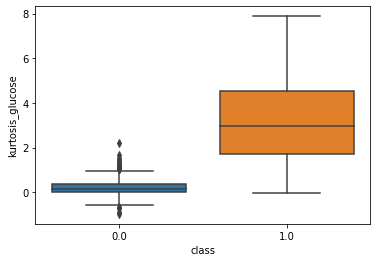

In [45]:
sns.boxplot('class', 'kurtosis_glucose', data=merged_valid_lin)

<Axes: xlabel='class', ylabel='skewness_glucose'>

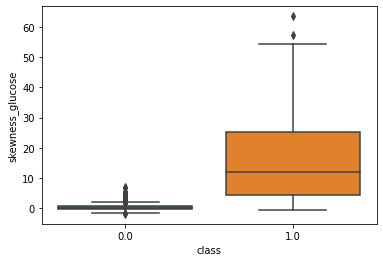

In [46]:
sns.boxplot('class', 'skewness_glucose', data=merged_valid_lin)

<Axes: xlabel='class', ylabel='std_oxygen'>

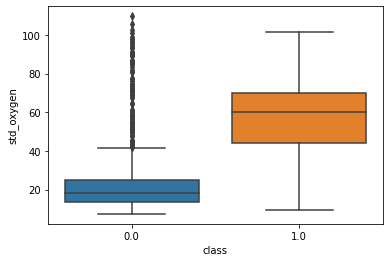

In [47]:
sns.boxplot('class', 'std_oxygen', data=merged_valid_lin)

<Axes: xlabel='class', ylabel='mean_oxygen'>

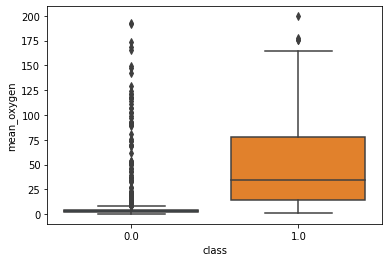

In [48]:
sns.boxplot('class', 'mean_oxygen', data=merged_valid_lin)

<Axes: xlabel='class', ylabel='kurtosis_oxygen'>

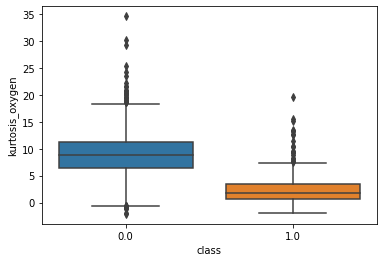

In [49]:
sns.boxplot('class', 'kurtosis_oxygen', data=merged_valid_lin)

<Axes: xlabel='class', ylabel='mean_glucose'>

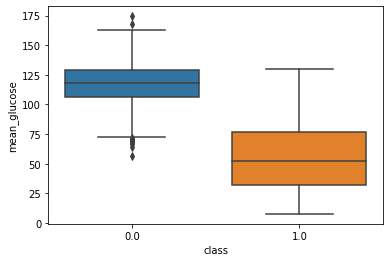

In [50]:
sns.boxplot('class', 'mean_glucose', data=merged_valid_lin)

We will use three attributes with the highest correlation: kurtosis_glucose, mean_glucose and skewness_glucose.

#### kurtosis_glucose

If kurtosis_glucose is greater than 2, then the person has a disease, the boxplot above showed us the information

In [51]:
r = (merged_train_lin['kurtosis_glucose'] > 2.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Train dataset")
print("F1 " + str(f1_score(r, merged_train_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_train_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_train_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_train_lin['class'])))

print("\n")

r = (merged_valid_lin['kurtosis_glucose'] > 2.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Valid dataset")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Train dataset
F1 0.870233183295824
Recall 0.9452220966878754
Precision 0.8309904798695283
Accuracy 0.9130434782608695


Valid dataset
F1 0.8838069150964221
Recall 0.9488225653078106
Precision 0.8477477612387313
Accuracy 0.9191456903127384


#### mean_glucose

If mean_glucose is lower than 75, then the person has no disease, the boxplot above showed us the information

In [52]:
r = (merged_train_lin['mean_glucose'] < 75.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Train dataset")
print("F1 " + str(f1_score(r, merged_train_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_train_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_train_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_train_lin['class'])))

print("\n")

r = (merged_valid_lin['mean_glucose'] < 75.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Valid dataset")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Train dataset
F1 0.8802996379573171
Recall 0.9401867984768473
Precision 0.8455328566240331
Accuracy 0.9181286549707602


Valid dataset
F1 0.8863514285367069
Recall 0.9279730857872692
Precision 0.8592800023959987
Accuracy 0.9183829138062548


#### skewness_glucose

If skewness_glucose is greater than 5, then the person has a disease, the boxplot above showed us the information

In [53]:
r = (merged_train_lin['skewness_glucose'] > 5.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Train dataset")
print("F1 " + str(f1_score(r, merged_train_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_train_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_train_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_train_lin['class'])))

print("\n")

r = (merged_valid_lin['skewness_glucose'] > 5.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Valid dataset")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average='macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average='macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Train dataset
F1 0.879831158653119
Recall 0.9477715753519116
Precision 0.8422739564106156
Accuracy 0.9186371726417493


Valid dataset
F1 0.8938856435056679
Recall 0.9427805145046524
Precision 0.863425080116206
Accuracy 0.9244851258581236


### Complex rules <a id='complex_rules'></a>

To create more complex rules, we visualize them via pairplot


Let's show glucose and oxygen with a correlation higher than 0.5 and lower than -0.5

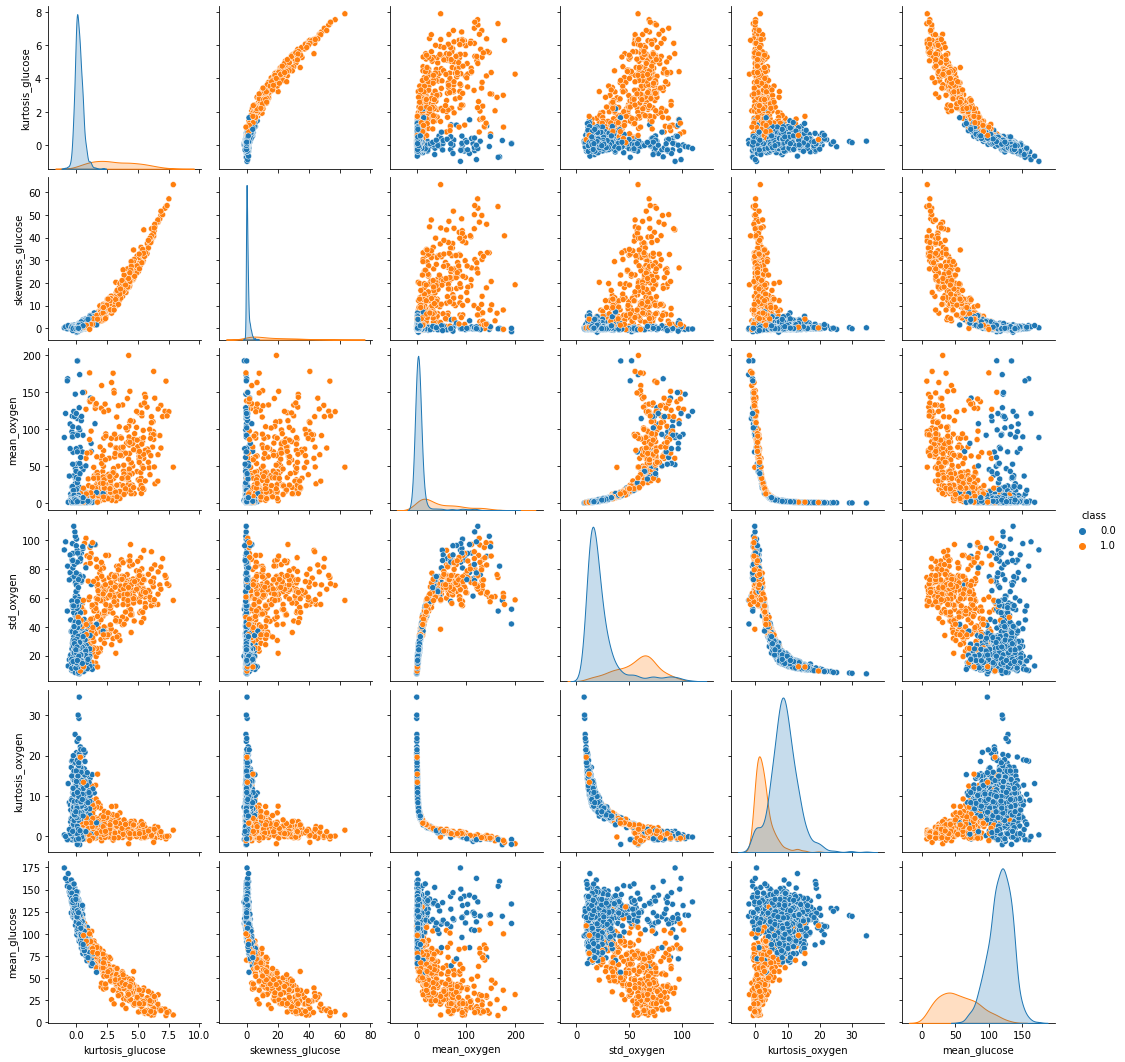

In [54]:
pplot = merged_valid_lin[['kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'mean_glucose', 'class']]
sns.pairplot(pplot, hue='class')

#### skewness_glucose and kurtosis_glucose

According to the pairplot, we chose these two attributes

If skewness_glucose is greater than 5 and kurtosis_glucose is greater than 2, then the person has a disease

In [55]:
x = (merged_train_lin['skewness_glucose'] > 5.0)
y = (merged_train_lin['kurtosis_glucose'] > 2.0)
r = x & y
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Train dataset")
print("F1 " + str(f1_score(r, merged_train_lin['class'], average= 'macro')))
print("Recall " + str(recall_score(r, merged_train_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_train_lin['class'], average= 'macro')))
print("Accuracy " + str(accuracy_score(r, merged_train_lin['class'])))

print("\n")

x = (merged_valid_lin['skewness_glucose'] > 5.0)
y = (merged_valid_lin['kurtosis_glucose'] > 2.0)
r = x & y
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Valid dataset")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average= 'macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average= 'macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Train dataset
F1 0.8632048378371655
Recall 0.9429620241122965
Precision 0.8230223523794885
Accuracy 0.9089753368929571


Valid dataset
F1 0.8763290883363655
Recall 0.9462534489554593
Precision 0.8390772410075173
Accuracy 0.9145690312738368


#### mean_glucose and skewness_glucose

According to the pairplot, we chose these two attributes

If mean_glucose is lower than 75 and skewness_glucose is greater than 5, then the person has a disease

In [56]:
x = (merged_train_lin['skewness_glucose'] > 5.0)
y = (merged_train_lin['mean_glucose'] < 75.0)
r = x & y
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Train dataset")
print("F1 " + str(f1_score(r, merged_train_lin['class'], average= 'macro')))
print("Recall " + str(recall_score(r, merged_train_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_train_lin['class'], average= 'macro')))
print("Accuracy " + str(accuracy_score(r, merged_train_lin['class'])))

print("\n")

x = (merged_valid_lin['skewness_glucose'] > 5.0)
y = (merged_valid_lin['mean_glucose'] < 75.0)
r = x & y
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Valid dataset")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average= 'macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average= 'macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Train dataset
F1 0.8664100378827284
Recall 0.9433240621583849
Precision 0.8268357093986635
Accuracy 0.9107551487414187


Valid dataset
F1 0.8784729384510417
Recall 0.9416759143663014
Precision 0.843303183683249
Accuracy 0.9153318077803204


### Dropping insignificant attributes <a id='dropping_attributes'></a>

In [57]:
merged_train_lin = merged_train_lin.drop('name', 1)
merged_train_lin = merged_train_lin.drop('address', 1)
merged_train_lin = merged_train_lin.drop('date_of_birth', 1)

merged_valid_lin = merged_valid_lin.drop('name', 1)
merged_valid_lin = merged_valid_lin.drop('address', 1)
merged_valid_lin = merged_valid_lin.drop('date_of_birth', 1)

merged_train_mean = merged_train_mean.drop('name', 1)
merged_train_mean = merged_train_mean.drop('address', 1)
merged_train_mean = merged_train_mean.drop('date_of_birth', 1)

merged_valid_mean = merged_valid_mean.drop('name', 1)
merged_valid_mean = merged_valid_mean.drop('address', 1)
merged_valid_mean = merged_valid_mean.drop('date_of_birth', 1)

### Change categorical attributes to numerical <a id='change_attributes'></a>

LabelEncoder is used to change categorical attributes to numeric

In [58]:
le = LabelEncoder() 

merged_train_mean['marital-status'] = le.fit_transform(merged_train_mean['marital-status'])
merged_valid_mean['marital-status']= le.transform(merged_valid_mean['marital-status'])

merged_train_mean['occupation'] = le.fit_transform(merged_train_mean['occupation'])
merged_valid_mean['occupation']= le.transform(merged_valid_mean['occupation'])

merged_train_mean['pregnant'] = le.fit_transform(merged_train_mean['pregnant'])
merged_valid_mean['pregnant']= le.transform(merged_valid_mean['pregnant'])

merged_train_mean['education-num'] = le.fit_transform(merged_train_mean['education-num'])
merged_valid_mean['education-num']= le.transform(merged_valid_mean['education-num'])

merged_train_mean['relationship'] = le.fit_transform(merged_train_mean['relationship'])
merged_valid_mean['relationship']= le.transform(merged_valid_mean['relationship'])

merged_train_mean['education'] = le.fit_transform(merged_train_mean['education'])
merged_valid_mean['education']= le.transform(merged_valid_mean['education'])

merged_train_mean['income'] = le.fit_transform(merged_train_mean['income'])
merged_valid_mean['income']= le.transform(merged_valid_mean['income'])

merged_train_mean['country'] = le.fit_transform(merged_train_mean['country'])
merged_valid_mean['country'] = le.fit_transform(merged_valid_mean['country'])

merged_train_mean['workclass'] = le.fit_transform(merged_train_mean['workclass'])
merged_valid_mean['workclass'] = le.fit_transform(merged_valid_mean['workclass'])

merged_train_mean['sex'] = le.fit_transform(merged_train_mean['sex'])
merged_valid_mean['sex']= le.transform(merged_valid_mean['sex'])

In [59]:
le1 = LabelEncoder() 

merged_train_lin['marital-status'] = le1.fit_transform(merged_train_lin['marital-status'])
merged_valid_lin['marital-status']= le1.transform(merged_valid_lin['marital-status'])

merged_train_lin['occupation'] = le1.fit_transform(merged_train_lin['occupation'])
merged_valid_lin['occupation']= le1.transform(merged_valid_lin['occupation'])

merged_train_lin['pregnant'] = le1.fit_transform(merged_train_lin['pregnant'])
merged_valid_lin['pregnant']= le1.transform(merged_valid_lin['pregnant'])

merged_train_lin['education-num'] = le1.fit_transform(merged_train_lin['education-num'])
merged_valid_lin['education-num']= le1.transform(merged_valid_lin['education-num'])

merged_train_lin['relationship'] = le1.fit_transform(merged_train_lin['relationship'])
merged_valid_lin['relationship']= le1.transform(merged_valid_lin['relationship'])

merged_train_lin['education'] = le1.fit_transform(merged_train_lin['education'])
merged_valid_lin['education']= le1.transform(merged_valid_lin['education'])

merged_train_lin['income'] = le1.fit_transform(merged_train_lin['income'])
merged_valid_lin['income']= le1.transform(merged_valid_lin['income'])

merged_train_lin['country'] = le1.fit_transform(merged_train_lin['country'])
merged_valid_lin['country'] = le1.fit_transform(merged_valid_lin['country'])

merged_train_lin['workclass'] = le1.fit_transform(merged_train_lin['workclass'])
merged_valid_lin['workclass'] = le1.fit_transform(merged_valid_lin['workclass'])

merged_train_lin['sex'] = le1.fit_transform(merged_train_lin['sex'])
merged_valid_lin['sex']= le1.transform(merged_valid_lin['sex'])

The ratio of training and validation data

In [60]:
len(merged_train_mean)

3933

In [61]:
len(merged_valid_mean)

1311

In [62]:
len(merged_train_lin)

3933

In [63]:
len(merged_valid_lin)

1311

### Finding the most optimal hyperparameters using Grid Search <a id='finding_hyperparameters'></a>

In this section, we use the Grid_Search function in which we perform a 10-fold cross-validation to see which hyperparameters achieve the best results.

#### Mean

First, we do a Grid Search on a dataset that has NaN values filled using Mean.

In [64]:
data_train_mean = merged_train_mean[merged_train_mean.columns.difference(['class'],sort= False)]
labels_train_mean = merged_train_mean['class']
data_val_mean = merged_valid_mean[merged_valid_mean.columns.difference(['class'],sort= False)]
labels_val_mean = merged_valid_mean['class']

In [65]:
new_best_mean = Grid_Search(data_train_mean, labels_train_mean)

Fitting 10 folds for each of 336 candidates, totalling 3360 fits
Best tree - hyperparameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 9, 'min_samples_leaf': 1}


In [66]:
preds = new_best_mean.predict(data_val_mean)

In [67]:
print("A tree filled with Mean")

print("\n")

print("F1 " + str(f1_score(preds, labels_val_mean, average= 'macro')))
print("Recall " + str(recall_score(preds, labels_val_mean, average= 'macro')))
print("Precision " + str(precision_score(preds, labels_val_mean, average= 'macro')))
print("Accuracy " + str(accuracy_score(preds, labels_val_mean)))

A tree filled with Mean


F1 0.955537383793887
Recall 0.9586019155832332
Precision 0.9525831860792476
Accuracy 0.965675057208238


#### Linear Regression

In [68]:
data_train_lin = merged_train_lin[merged_train_lin.columns.difference(['class'],sort= False)]
labels_train_lin = merged_train_lin['class']
data_val_lin = merged_valid_lin[merged_valid_lin.columns.difference(['class'],sort= False)]
labels_val_lin = merged_valid_lin['class']

In [69]:
new_best_lin = Grid_Search(data_train_lin, labels_train_lin)

Fitting 10 folds for each of 336 candidates, totalling 3360 fits
Best tree - hyperparameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 9, 'min_samples_leaf': 1}


In [70]:
preds1 = new_best_lin.predict(data_val_lin)

In [71]:
print("Tree filled by Linear Regression")

print("\n")

print("F1 " + str(f1_score(preds1, labels_val_lin, average= 'macro')))
print("Recall " + str(recall_score(preds1, labels_val_lin, average= 'macro')))
print("Precision " + str(precision_score(preds1, labels_val_lin, average= 'macro')))
print("Accuracy " + str(accuracy_score(preds1, labels_val_lin)))

Tree filled by Linear Regression


F1 0.949797910705289
Recall 0.9510682962677397
Precision 0.9485474257989157
Accuracy 0.9610983981693364


The tree that was filled using Linear Regression and appropriate hyperparameters has higher accuracy than the tree that was filled with Mean. The accuracy results show us this above. We can say that filling using different methods has an impact on the final result.

### Comparison of the best manual rule with the best trained classifier <a id='comparison'></a>

#### Trained classifier

In [72]:
print("Tree filled by Linear Regression")

print("\n")

print("F1 " + str(f1_score(preds1, labels_val_lin, average= 'macro')))
print("Recall " + str(recall_score(preds1, labels_val_lin, average= 'macro')))
print("Precision " + str(precision_score(preds1, labels_val_lin, average= 'macro')))
print("Accuracy " + str(accuracy_score(preds1, labels_val_lin)))

Tree filled by Linear Regression


F1 0.949797910705289
Recall 0.9510682962677397
Precision 0.9485474257989157
Accuracy 0.9610983981693364


#### Manual rule

In [73]:
r = (merged_valid_lin['skewness_glucose'] > 5.0)
r.replace(True, 1, inplace = True)
r.replace(False, 0, inplace = True)
print("Manual rule for skewness glucose\n")
print("F1 " + str(f1_score(r, merged_valid_lin['class'], average= 'macro')))
print("Recall " + str(recall_score(r, merged_valid_lin['class'], average='macro')))
print("Precision " + str(precision_score(r, merged_valid_lin['class'], average= 'macro')))
print("Accuracy " + str(accuracy_score(r, merged_valid_lin['class'])))

Manual rule for skewness glucose

F1 0.8938856435056679
Recall 0.9427805145046524
Precision 0.863425080116206
Accuracy 0.9244851258581236


It is clear from the results that the trained classifier performed better.